In [18]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the file paths
input_file_path = 'node-coordinate.rpt'
# output_file_path = 'extracted_table.csv'

extracting node-coordinates:

In [2]:
# Read the .rpt file
with open(input_file_path, 'r') as file:
    lines = file.readlines()

# Identify the start of the table
start_line = 13

# Extract the data from the table
table_data = []
for line in lines[start_line + 1:]:
    if line.strip() == "" or line.startswith("----") or "X" in line or "Orig. Coords" in line:
        continue
    parts = line.split()
    part_instance = parts[0]
    node_id = int(parts[1])
    orig_coords = list(map(float, parts[2:5]))
    def_coords = list(map(float, parts[5:]))
    table_data.append([part_instance, node_id] + orig_coords + def_coords)

# Create a DataFrame
columns = ['Part Instance', 'Node ID', 'Orig X', 'Orig Y', 'Orig Z', 'Def X', 'Def Y', 'Def Z']
df_node_coords = pd.DataFrame(table_data, columns=columns)

In [3]:
df_node_coords["Orig Y"].max()

np.float64(244.44)

In [10]:
nodes_coordinates = df_node_coords[["Node ID", "Orig X", "Orig Y", "Orig Z"]]
nodes_coordinates.reset_index(inplace=True, drop=True)
nodes_coordinates.head()

,Node ID,Orig X,Orig Y,Orig Z
0,1,89.7910,232.513,28.85
1,2,113.9430,213.146,28.85
2,3,133.2090,236.151,28.85
3,4,80.7107,213.150,28.85
4,5,103.8230,202.393,28.85


In [11]:
nodes_coordinates.loc[:, ["Orig X", "Orig Y", "Orig Z"]] = nodes_coordinates[["Orig X", "Orig Y", "Orig Z"]]/0.148
nodes_coordinates.head()

,Node ID,Orig X,Orig Y,Orig Z
0,1,606.695946,1571.033784,194.932432
1,2,769.885135,1440.175676,194.932432
2,3,900.060811,1595.614865,194.932432
3,4,545.342568,1440.202703,194.932432
4,5,701.506757,1367.520270,194.932432


In [12]:
node_ids = nodes_coordinates["Node ID"].tolist()
# nodes_in_first_layer_id

In [29]:
nodes_coordinates.loc[nodes_coordinates["Node ID"].isin([572, 584, 53, 52]), "Orig Z"]

51     194.932432
52     194.932432
571    194.932432
583    194.932432
Name: Orig Z, dtype: float64

extracting node-elements (each element is cnosisting of what nodes?):

In [13]:
import pandas as pd

# Define the file paths
input_file_path_element = 'element-node.rpt'
# output_file_path = 'extracted_table.csv'

In [46]:
# Read the .rpt file
with open(input_file_path_element, 'r') as file:
    lines = file.readlines()

node_ids_set = set(node_ids)  # Convert to set if not already a set
# Identify the start of the table
start_line = 15

# Extract the data from the table
table_data = []
not_table_data = []

for line in lines[start_line + 1:]:
    if line.strip() == "" or line.startswith("----") or "Part" in line or "X" in line or "Orig. Coords" in line:
        continue
    parts = line.split()
    part_instance = parts[0]
    element_id = int(parts[1])
    Type = str(parts[2])
    attached_nodes = list(map(int, parts[3:]))
    first_attached_node = attached_nodes[0]

    # Use list comprehension to filter nodes that have same Orig Z
    attached_nodes = [
    node for node in attached_nodes 
    if nodes_coordinates.loc[nodes_coordinates["Node ID"] == node, "Orig Z"].values[0] 
    == nodes_coordinates.loc[nodes_coordinates["Node ID"] == first_attached_node, "Orig Z"].values[0]
    ]

    element_to_be_append = [part_instance,  element_id, Type] + attached_nodes

    if len(element_to_be_append) == 7:
        table_data.append(element_to_be_append)



In [47]:
len(table_data)

40768

In [48]:
# Create a DataFrame
columns = ['Part Instance', 'Element ID', 'Type', "Attached nodes 1", "Attached nodes 2", "Attached nodes 3", "Attached nodes 4"]
zone_nodes = pd.DataFrame(table_data, columns=columns)
zone_nodes.head()

,Part Instance,Element ID,Type,Attached nodes 1,Attached nodes 2,Attached nodes 3,Attached nodes 4
0,FEM-1,1,C3D8R,572,584,53,52
1,FEM-1,2,C3D8R,584,585,54,53
2,FEM-1,3,C3D8R,585,586,55,54
3,FEM-1,4,C3D8R,586,587,56,55
4,FEM-1,5,C3D8R,587,588,57,56


In [20]:
zone_nodes.dtypes

Part Instance       object
Element ID           int64
Type                object
Attached nodes 1     int64
Attached nodes 2     int64
Attached nodes 3     int64
Attached nodes 4     int64
dtype: object

Continue Process:

In [50]:
zone_nodes

,Part Instance,Element ID,Type,Attached nodes 1,Attached nodes 2,Attached nodes 3,Attached nodes 4
0,FEM-1,1,C3D8R,572,584,53,52
1,FEM-1,2,C3D8R,584,585,54,53
2,FEM-1,3,C3D8R,585,586,55,54
3,FEM-1,4,C3D8R,586,587,56,55
4,FEM-1,5,C3D8R,587,588,57,56
...,...,...,...,...,...,...,...
40763,FEM-1,40764,C3D8R,42924,42923,40281,40282
40764,FEM-1,40765,C3D8R,42923,40277,39894,40281
40765,FEM-1,40766,C3D8R,42923,40414,39895,40277
40766,FEM-1,40767,C3D8R,42924,40415,40414,42923


In [52]:
# تابع برای رسم خطوط بین نودهای هر المان
def draw_zone_boundaries(image, nodes_coordinates, zone_nodes):
    for zone in zone_nodes:
        # گرفتن مختصات نودهای هر zone
        pts = np.array([nodes_coordinates[node_id] for node_id in zone], np.int32)
        pts = pts.reshape((-1, 1, 2))
        # رسم خط های مرزی zone ها
        cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=1)

    return image

In [53]:
# تابع برای محاسبه میانگین روشنایی هر zone
def calculate_zone_brightness(image, nodes_coordinates, zone_nodes):
    zone_brightness = []
    for zone in zone_nodes:
        # گرفتن مختصات نودهای هر zone
        pts = np.array([nodes_coordinates[node_id] for node_id in zone], np.int32)
        # ایجاد ماسک برای zone
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [pts], 255)
        # محاسبه میانگین روشنایی منطقه با استفاده از ماسک
        mean_brightness = cv2.mean(image, mask=mask)[0]
        zone_brightness.append(mean_brightness)
    
    return zone_brightness

In [54]:
# تابع اصلی برای پردازش تصویر و محاسبه میانگین روشنایی هر المان
def process_image(image_path, nodes_df, elements_df):
    # بارگذاری تصویر
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # استخراج مختصات نودها
    nodes_coordinates = {row['Node ID']: (row['Orig X'], row['Orig Y']) for _, row in nodes_df.iterrows()}
    
    # استخراج نودهای هر المان
    zone_nodes = elements_df[['Attached nodes 1', 'Attached nodes 2', 'Attached nodes 3', 'Attached nodes 4']].values.tolist()
    
    # رسم مرزهای المان‌ها روی تصویر
    image_with_zones = draw_zone_boundaries(image.copy(), nodes_coordinates, zone_nodes)
    
    # محاسبه میانگین روشنایی هر المان (از تصویر خاکستری)
    zone_brightness = calculate_zone_brightness(gray_image, nodes_coordinates, zone_nodes)
    
    # افزودن میانگین روشنایی به دیتافریم المان‌ها
    elements_df['Mean Brightness'] = zone_brightness
    
    # نمایش تصویر همراه با مرزها
    plt.imshow(cv2.cvtColor(image_with_zones, cv2.COLOR_BGR2RGB))
    plt.title('Image with Zone Boundaries')
    plt.show()

    return elements_df

In [57]:
import os
image_path = "D:\\Mammad's Project\\Thresholded_Images (1)\\00000005.png"  # مسیر تصویر خود را وارد کنید
print(os.path.exists(image_path))  # Should return True if the image exists

False


TypeError: Image data of dtype object cannot be converted to float

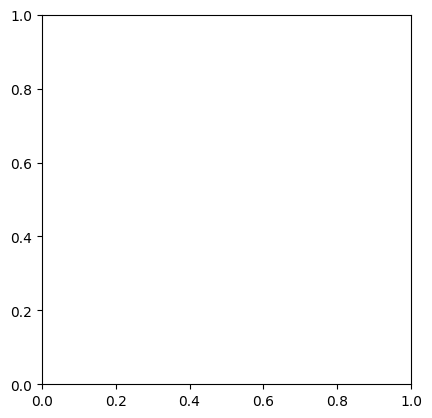

In [56]:
image = cv2.imread(image_path)
# cv2.imshow("image", image)
plt.imshow(image)

In [29]:
nodes_coordinates["Orig Y"] = -nodes_coordinates["Orig Y"] + image.shape[0]

In [30]:
print(image.shape)

(2879, 2854, 3)


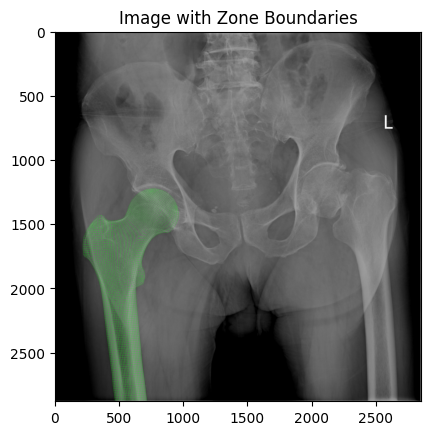

     Part Instance  Element ID   Type  Attached nodes 1  Attached nodes 2  \
0            FEM-1       37857  C3D8R             43496             43508   
1            FEM-1       37858  C3D8R             43508             43509   
2            FEM-1       37859  C3D8R             43509             43510   
3            FEM-1       37860  C3D8R             43510             43511   
4            FEM-1       37861  C3D8R             43511             43512   
...            ...         ...    ...               ...               ...   
2907         FEM-1       40764  C3D8R             45990             45989   
2908         FEM-1       40765  C3D8R             45989             43343   
2909         FEM-1       40766  C3D8R             45989             43480   
2910         FEM-1       40767  C3D8R             45990             43481   
2911         FEM-1       40768  C3D8R             45988             43482   

      Attached nodes 3  Attached nodes 4  Mean Brightness  
0              

In [31]:
# اجرای تابع اصلی
processed_elements_df = process_image(image_path, nodes_coordinates, zone_nodes)

# نمایش دیتافریم نهایی با میانگین روشنایی هر المان
print(processed_elements_df)

In [32]:
processed_elements_df["Mean Brightness"].value_counts()

Mean Brightness
107.125000    2
104.414286    2
107.105469    2
101.924171    2
100.000000    2
             ..
98.259804     1
128.348214    1
128.957265    1
129.134921    1
126.020548    1
Name: count, Length: 2896, dtype: int64

In [33]:
processed_elements_df.head()

,Part Instance,Element ID,Type,Attached nodes 1,Attached nodes 2,Attached nodes 3,Attached nodes 4,Mean Brightness
0,FEM-1,37857,C3D8R,43496,43508,42977,42976,128.392857
1,FEM-1,37858,C3D8R,43508,43509,42978,42977,127.729508
2,FEM-1,37859,C3D8R,43509,43510,42979,42978,127.443662
3,FEM-1,37860,C3D8R,43510,43511,42980,42979,123.854545
4,FEM-1,37861,C3D8R,43511,43512,42981,42980,124.252809


In [34]:
# Save the DataFrame to a CSV file
output_file_path = "zones_mean_brightness.csv"
processed_elements_df.to_csv(output_file_path, index=False)

output_file_path = "zones_mean_brightness.xlsx"
processed_elements_df.to_excel(output_file_path, index=False)

print(f"Table extracted and saved to {output_file_path} as csv and excel.")

Table extracted and saved to zones_mean_brightness.csv
